# Metrics

In [55]:
import sys, os
sys.path.append('..')
from utils.utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
cfg = {
'EXPERIMENT': 'center_',
'DATASET': 'sa1b',
'MODEL': 'MobileSAM',
'TARGET': 'SAM',
'SPARSITY': 0,
'CLASS': 0,
'MODE': '',
'METRIC': 'iou'
}
cfg['ROOT'], cfg['N'], cfg['CLASSES'], cfg['SUPERCLASSES'], cfg['SUP_N'] = get_dataset_info(cfg['DATASET'])
cfg['SUP_L'] = {v: k for k, v in cfg['SUP_N'].items()}

## Compute Metrics

In [57]:
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
df_p = pd.read_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_prompts.pkl")
df_0 = pd.read_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_0.pkl")
df_s = pd.read_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")

In [59]:
df_p.head()

,name,prompt,class,image_shape,score,s_class,shape
0,sa_231941,"[457, 942]",None,"(2250, 3)",0,None,"(1500, 2250)"
1,sa_234721,"[1619, 1467]",None,"(2247, 3)",0,None,"(1500, 2247)"
2,sa_234928,"[397, 1008]",None,"(1500, 3)",0,None,"(2250, 1500)"
3,sa_227443,"[672, 694]",None,"(2250, 3)",0,None,"(1500, 2250)"
4,sa_231190,"[2110, 419]",None,"(2250, 3)",0,None,"(1500, 2250)"


In [60]:
# Add Image Shape
if 'shape' not in df_p.keys():
    df_p = add_image_shape(df_p, cfg)
    df_p.head()
    df_p.to_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_prompts.pkl")

In [61]:
df_p['score'] = df_p.apply(lambda s: 0, axis=1)
df_p['s_class'] = df_p.apply(lambda s: None, axis=1)
# df_p['mask_size'] = df_p.apply(get_mask_size, axis=1)

In [38]:
#df_0['shape'] = df_0.apply(lambda s: s['mask']['size'], axis=1)
#df_0['mask_size'] = df_0.apply(get_mask_size, axis=1)
#df_0.to_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_0.pkl")

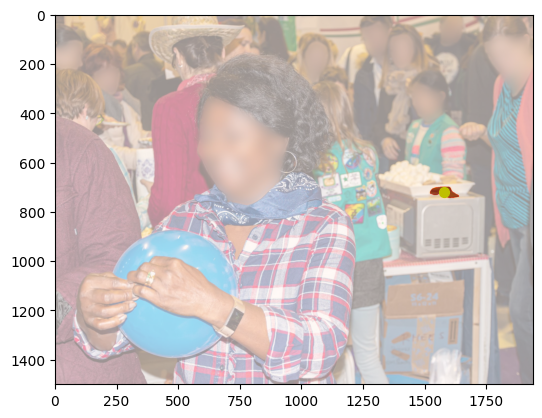

In [39]:
i = 900
plt.imshow(get_image(df_p['name'][i], cfg))
plt.scatter(*df_p['prompt'][i], c='y', s=50)
#plt.imshow(get_full_mask(df_s['mask'][i], df_s['mask_origin'][i], df_p['shape'][i]), alpha=0.6, cmap='Blues')
plt.imshow(get_full_mask(df_0['mask'][i], df_0['mask_origin'][i], df_p['shape'][i]), alpha=0.6, cmap='Reds')
#plt.imshow(get_full_mask(df_p['mask'][i], df_p['mask_origin'][i], df_p['shape'][i]), alpha=0.6, cmap='Greens')
plt.show()

In [30]:
# SAM vs GT
if os.path.exists(f"../results/analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl"):
    df_g0 = pd.read_pickle(f"../results/analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
else:
    df_g0 = get_analytics(df_p, df_0, df_p, cfg, skip_empty=True)
    df_g0.to_pickle(f"../results/analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
    df_g0.head()

ValueError: could not broadcast input array from shape (178,2246) into shape (178,926)

In [46]:
# MobileSAM vs SAM
if os.path.exists(f"../results/analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl"):
    df_0s = pd.read_pickle(f"../results/analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
else:
    df_0s = get_analytics(df_0, df_s, df_p, cfg, skip_empty=True)
    df_0s.to_pickle(f"../results/analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
    df_0s.head()

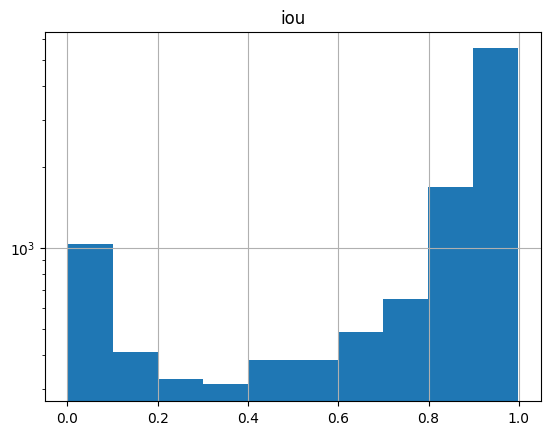

0.7321702038248608

In [45]:
# MobileSAM vs SAM
df_0s.hist(column='iou')
plt.semilogy()
plt.show()
df_0s['iou'].mean()

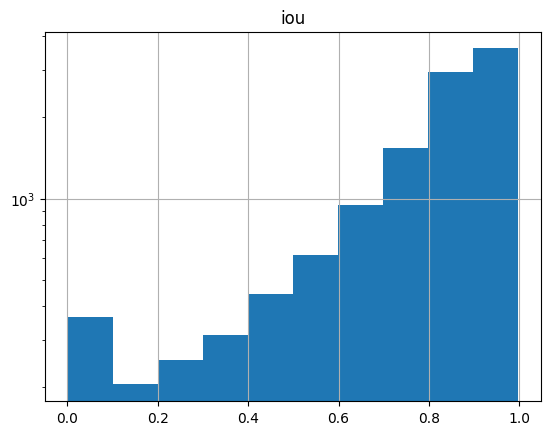

0.7528994331067524

In [11]:
# MobileSAMft vs SAM
df_0s.hist(column='iou')
plt.semilogy()
plt.show()
df_0s['iou'].mean()

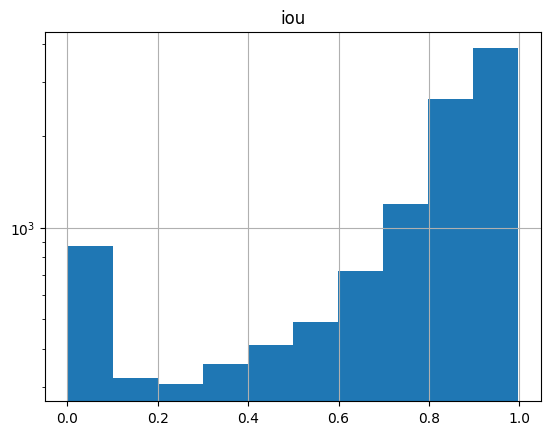

0.7180500876997522

In [41]:
# MobileSAMft(nosize) vs SAM
df_0s.hist(column='iou')
plt.semilogy()
plt.show()
df_0s['iou'].mean()

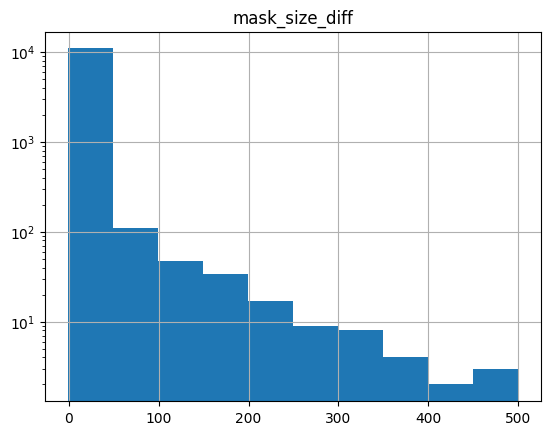

3.6695208048831858

In [47]:
# MobileSAM vs SAM
df_0s.hist(column='mask_size_diff')
plt.semilogy()
plt.show()
df_0s['mask_size_diff'].mean()

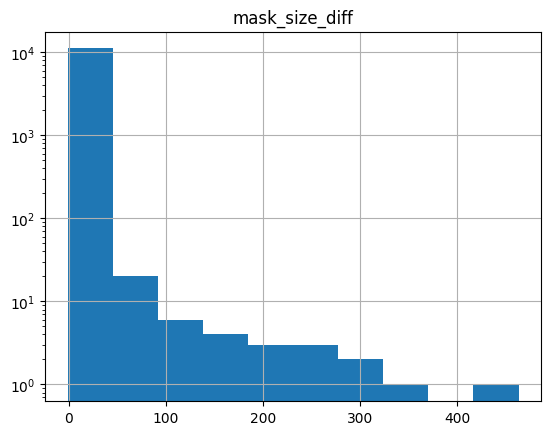

0.6611344189550599

In [12]:
# MobileSAMft vs SAM
df_0s.hist(column='mask_size_diff')
plt.semilogy()
plt.show()
df_0s['mask_size_diff'].mean()

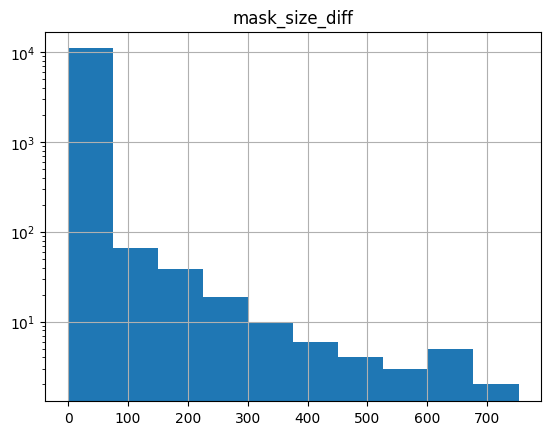

3.8330036080867753

In [42]:
# MobileSAMft(nosize) vs SAM
df_0s.hist(column='mask_size_diff')
plt.semilogy()
plt.show()
df_0s['mask_size_diff'].mean()

## Batch Save Analytics

In [ ]:
save_analytics(cfg)

In [ ]:
# get_summary(cfg)

## Global Analytics

In [ ]:
# Save Summary
summary = []
for n in MODELS[1:]:
    cfg['MODEL'] = n
    summary.append(get_summary(cfg))
summary = pd.concat(summary)
summary.to_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_summary.pkl")

In [ ]:
cfg['MODE'] = ''
cfg['SPARSITY'] = 0
for t in METRICS:
    cfg['METRIC'] = t
    summary = []
    for n in MODELS[1:]:
        cfg['MODEL'] = n
        summary.append(get_summary(cfg))
    summary = pd.concat(summary)
    get_hists(summary, cfg, save=True, plot=True)
    plt.clf()

## Global Curves

In [ ]:
summary = pd.read_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_summary.pkl")

for m in METRICS:
    cfg['METRIC'] = m
    get_curves(summary, cfg, std=False, plot=True, save=True)

## Class-wise Analytics

In [ ]:
# Save Summary
summary = []
for m in MODES:
    cfg['MODE'] = m
    for s in SPARSITIES:
        cfg['SPARSITY'] = s
        summary.append(get_summary(cfg, classwise=True))

cfg['MODE'] = ''
cfg['SPARSITY'] = 0
for n in MODELS[1:]:
    cfg['MODEL'] = n
    summary.append(get_summary(cfg, classwise=True))
summary = pd.concat(summary)
summary.to_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_classwise.pkl")

In [ ]:
d = summary[summary['pruning']=='_gup']
d = d[d['id']==50]
d = d[d['class']!=0]
get_hists(d, cfg, save=False, plot=True)

## Class-wise Curves

In [ ]:
summary = pd.read_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_classwise.pkl")

In [ ]:
def get_classwise_curves(d, cfg, plot=True, save=False):
    _, ax = plt.subplots()
    ax.grid()
    ax.title.set_text(cfg['METRIC'].replace('_', ' ').capitalize())
    ax.plot(PARAMS['SAM'], SAM[cfg['METRIC']], 'o')
     
    for c in range(1, d.shape[1]):
        if cfg['MODEL'] == 'SAM':
            p = (1 - d[:,c,1]/100) * PARAMS['SAM'] 
        else:
            p = PARAMS[d[:,c,1][0]]
        ax.plot(p, d[:,c,2], '-o', label=f"{cfg['SUP_L'][c]} ({d[0,c,3]})")
    # Shrink current axis's height by 10% on the bottom
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=4, fontsize=9)   
    #plt.legend(loc='best', fontsize=9, ncol=2)
    plt.xlabel('Parameters')
    plt.ylabel(cfg['METRIC'].replace('_', ' ').capitalize())
    plt.axvline(PARAMS['SAM'], linestyle='--')
    plt.axhline(SAM[cfg['METRIC']], linestyle='--')
    plt.semilogx()
    if save:
        plt.savefig(f"figures/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['METRIC']}_{cfg['MODEL']}{cfg['MODE']}_curves_classwise.pdf", bbox_inches='tight')
    if plot:
        plt.show()
    plt.clf()

In [ ]:
# GUP
for m in METRICS:
    cfg['METRIC'] = m
    d = summary[summary['pruning']=='_gup'][['class', 'id', cfg['METRIC'], 'n']].values.reshape(9, 13, -1)
    get_classwise_curves(d, cfg, plot=True, save=True)

# SparseGPT
cfg['MODE'] = '_gup'
for m in METRICS:
    cfg['METRIC'] = m
    d = summary[summary['id'].str.isalpha().isnull()]
    d = d[d['pruning']!='_gup'][['class', 'id', cfg['METRIC'], 'n']].values.reshape(9, 13, -1)
    get_classwise_curves(d, cfg, plot=True, save=True)

# FastSAM
# cfg['MODEL'] = 'FastSAM'
# for m in METRICS:
#     cfg['METRIC'] = m
#     d = summary[summary['id']==cfg['MODEL']][['class', 'id', cfg['METRIC'], 'n']].values.reshape(1, 13, -1)
#     get_classwise_curves(d, cfg, plot=True, save=True)

# MobileSAM
# cfg['MODEL'] = 'MobileSAM'
# for m in METRICS:
#     cfg['METRIC'] = m
#     d = summary[summary['id']==cfg['MODEL']][['class', 'id', cfg['METRIC'], 'n']].values.reshape(1, 13, -1)
#     get_classwise_curves(d, cfg, plot=True, save=True)

# Mobile&FastSAM
cfg['MODEL'] = 'Mobile&FastSAM'
for m in METRICS:
    cfg['METRIC'] = m
    d = summary[summary['id'].str.isalpha().notnull()][['class', 'id', cfg['METRIC'], 'n']].values.reshape(1, 13, -1)
    get_classwise_curves(d, cfg, plot=True, save=True)

In [ ]:
def get_forgettability_curve_dissimilarity(d, cfg, plot=True, save=False):
    fcd = np.zeros((d.shape[1], d.shape[1]))
    for c1 in range(d.shape[1]):
        for c2 in range(c1, d.shape[1]):
            if c1 == c2:
                continue
            fcd[c1, c2] = ((d[:,c1,2] - d[:,c2,2])**2).mean()
            fcd[c2, c1] = fcd[c1, c2]

    plt.imshow(fcd, interpolation='nearest')
    plt.xticks(range(12), [cfg['SUP_L'][i] for i in range(1, 13)], rotation=90)
    plt.yticks(range(12), [cfg['SUP_L'][i] for i in range(1, 13)])
    plt.title('Forgettability Curve Dissimilarity - GUP')
    plt.colorbar()
    if save:
        plt.savefig(f"figures/{cfg['EXPERIMENT']}{cfg['DATASET']}{cfg['MODE']}_fcd.pdf", bbox_inches='tight')
    if plot:
        plt.show()
    else:
        plt.clf()


In [ ]:
if cfg['MODE'] == '':
    # SparseGPT
    d = summary[summary['id'].str.isalpha().isnull()]
    d = d[d['pruning']!='_gup'][['class', 'id', cfg['METRIC'], 'n']].values.reshape(9, 13, -1)[:,1:,:]
elif cfg['MODE'] == '_gup':
    # GUP
    d = summary[summary['pruning']=='_gup'][['class', 'id', cfg['METRIC']]].values.reshape(9, 13, -1)[:,1:,:]

In [ ]:
get_forgettability_curve_dissimilarity(d, cfg, plot=True, save=True)

## Cluster Analytics

In [ ]:
df = pd.read_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
df.head()

In [ ]:
df.hist(column='iou')
plt.semilogy()
plt.show()

In [ ]:
df = add_superclass(df, cfg)
df['mask_size_target'] = (df['mask_size'] - df['mask_size_diff'] * 1e-5) / (1 + df['mask_size_diff'])
df['f1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])

In [ ]:
features = ['iou', 'precision', 'recall', 'mask_size', 'mask_size_diff', 'superclass']
data = df[features].values

In [ ]:
df['cluster'] = get_clusters(data, cfg, plot=True, save=False)
#df.to_pickle(f"analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")

In [ ]:
from itertools import product
def prod(l1, l2):
   return list(product(l1, l2))

M = ['iou', 'precision', 'recall']

fig, axs = plt.subplots(3, 3, sharex=True, sharey='row', figsize=(10,8))
for (ax, (c,m)) in zip(axs.flat, prod(range(3), M)):
    y, x = np.histogram(df[df['cluster']==c][m])
    ax.bar(x[:-1], y, width=x[1]-x[0], alpha=1)
    ax.set_title(f"[{c}] {m}", fontsize=10)
    ax.semilogy()
plt.suptitle(f"{cfg['MODEL']} {cfg['MODE']}", fontsize=12)
plt.savefig(f"figures/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}_clusters.pdf", bbox_inches='tight')
plt.show()

## CIEs

In [20]:
df_c = pd.read_pickle(f"../results/analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
df_0 = pd.read_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_0.pkl")
df_s = pd.read_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")

In [21]:
N = int(0.05*len(df_c))
min_iou = df_c.nsmallest(N,
                         ['iou'])

In [22]:
df_c['iou'].mean(), min_iou['iou'].mean()

(0.697111911925412, 0.006913624598182221)

Legend: Target -> Orange, Prediction -> Blue


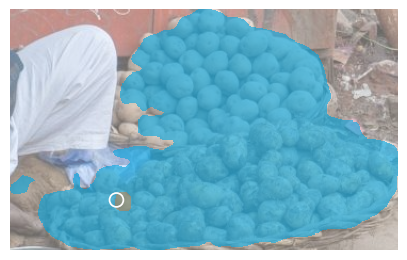

ID: sa_233649, PromptClass: None, TargetClass: None, PredClass: None,
ScoreDiff: 0.0496, MaskSizeDiff: 13.0847, IoU: 0.0050, Precision: 0.0050, Recall: 1.0000


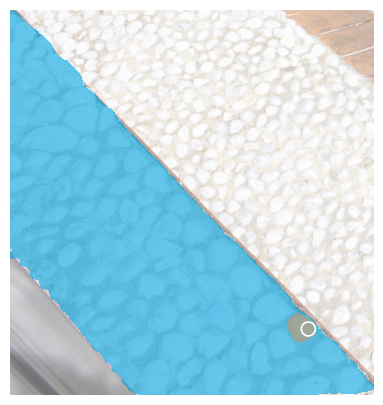

ID: sa_225079, PromptClass: None, TargetClass: None, PredClass: None,
ScoreDiff: 0.0002, MaskSizeDiff: 35.4071, IoU: 0.0095, Precision: 0.0095, Recall: 1.0000


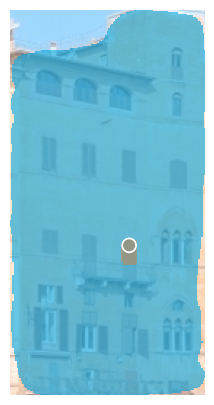

ID: sa_228646, PromptClass: None, TargetClass: None, PredClass: None,
ScoreDiff: 0.1082, MaskSizeDiff: 7.7940, IoU: 0.0058, Precision: 0.0058, Recall: 1.0000


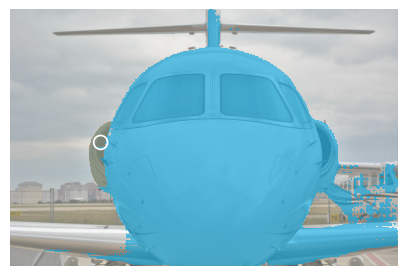

ID: sa_229014, PromptClass: None, TargetClass: None, PredClass: None,
ScoreDiff: 0.0289, MaskSizeDiff: 48.1373, IoU: 0.0177, Precision: 0.0177, Recall: 0.9790


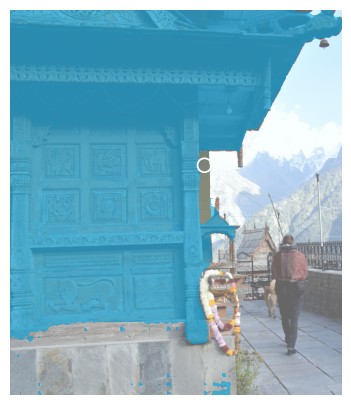

ID: sa_233802, PromptClass: None, TargetClass: None, PredClass: None,
ScoreDiff: -0.0373, MaskSizeDiff: 75.6227, IoU: 0.0100, Precision: 0.0100, Recall: 0.9977


In [23]:
show_samples(pie_df=min_iou, target_df=df_0, pred_df=df_s, cfg=cfg, prompt_zoom=False, n=5, random=True, save=False)

## Small Masks

In [62]:
df = pd.read_pickle(f"../results/analytics/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")
df_0 = pd.read_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_0.pkl")
df_s = pd.read_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['MODEL']}_{cfg['SPARSITY']}{cfg['MODE']}.pkl")

In [ ]:
# Filter out SAM's wrong masks (out of prompt)
df_0['check'] = df_0.apply(lambda s: check_prompt(s), axis=1)
df_0.hist(column='check', range=(0,.1))

df_0 = df_0[df_0['check']!=0]
df = df[(df.name.isin(df_0.name))]
df_s = df_s[(df_s.name.isin(df_0.name))]

In [ ]:
df_s['check'] = df_s.apply(lambda s: check_prompt(s), axis=1)
df_s.hist(column='check', range=(0,.1))

df_s = df_s[df_s['check']!=0]
df = df[(df.name.isin(df_s.name))]
df_0 = df_0[(df_0.name.isin(df_s.name))]

In [ ]:
df['mask_size_target'] = (df['mask_size'] - df['mask_size_diff'] * 1e-5) / (1 + df['mask_size_diff'])
df['f1'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])

In [63]:
N = int(0.1*len(df))
min_iou = df.nsmallest(N, ['iou']) # [df['iou']>0.001]

In [ ]:
weights = np.ones_like(df['mask_size_target']) / len(df['mask_size_target'])
df.hist(column='mask_size_target', range=(0,1), weights=weights, cumulative=True, bins=100)
plt.show()

In [ ]:
weights = np.ones_like(min_iou['mask_size_target']) / len(min_iou['mask_size_target'])
min_iou.hist(column='mask_size_target', range=(0,1), weights=weights, cumulative=True, bins=100)
plt.show()

In [ ]:
print(len(df))
print(len(df[df['mask_size_diff'] < -0.5]) / len(df) * 100)
print(len(df[df['mask_size_diff'] > 0.5]) / len(df) * 100)

In [ ]:
print(len(min_iou))
print(len(min_iou[min_iou['mask_size_diff'] < -0.5]) / len(min_iou) * 100)
print(len(min_iou[min_iou['mask_size_diff'] > 0.5]) / len(min_iou) * 100)

0.07207228581326885

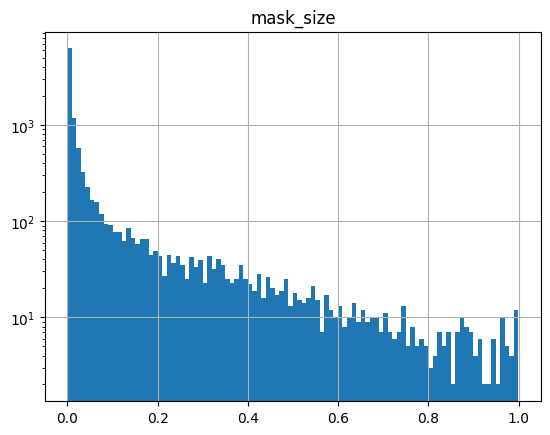

In [64]:
df.hist(column='mask_size', bins=100)
plt.semilogy()
df['mask_size'].mean()

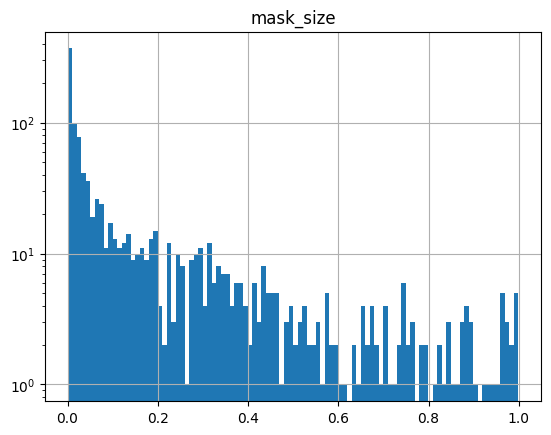

0.15209655783725196

In [65]:
min_iou.hist(column='mask_size', bins=100)
plt.semilogy()
#plt.ylim(1, 350)
plt.show()
min_iou['mask_size'].mean()

In [ ]:
min_iou.sort_values(by=['f1'], ascending=True, inplace=True)

In [ ]:
show_samples(pie_df=min_iou, target_df=df_0, pred_df=df_s, cfg=cfg, prompt_zoom=False, thr=50, n=10, random=True, save=False, zoom=True)

## Compare with Ground Truth

In [19]:
import json
from pycocotools import mask as mask_utils
import pandas as pd
import numpy as np

In [ ]:
df_p = pd.read_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_prompts.pkl")
df_p.head()

In [20]:
def get_anns(name, cfg):
    ann_path = cfg['ROOT'].joinpath(f"sa_000020/{name}.json")
    with open(ann_path, 'r') as ann_path:
        return json.load(ann_path)
    
def prompt_in_bbox(prompt, bbox):
    return prompt[0] > bbox[0] and prompt[1] > bbox[1] and prompt[0] < bbox[0]+bbox[2] and prompt[1] < bbox[1]+bbox[3]

def prompt_in_mask(prompt, ann):
    if prompt_in_bbox(prompt, ann['bbox']):
        mask = mask_utils.decode(ann['segmentation'])
        if mask[prompt[1], prompt[0]]:
            return mask
    return

def get_ground_truth_mask(s, cfg):
    prompt = s['prompt']
    anns = get_anns(s['name'], cfg)['annotations']
    for ann in anns:
        mask = prompt_in_mask(prompt, ann)
        if mask is not None:
            return mask.astype(bool)
    print(s['name'], ' No mask found')
    return np.zeros((s['shape'][0], s['shape'][1])).astype(bool)

def get_ground_truth(df, cfg):
    df['gt'] = df.apply(lambda s: get_mask_limits([get_ground_truth_mask(s, cfg)]), axis=1)
    return df

In [21]:
df_p = get_ground_truth(df_p, cfg)

sa_231886  No mask found
sa_227070  No mask found
sa_226004  No mask found
sa_228189  No mask found
sa_230402  No mask found
sa_233894  No mask found
sa_226553  No mask found
sa_227221  No mask found
sa_234154  No mask found
sa_230010  No mask found
sa_227632  No mask found
sa_229976  No mask found
sa_229517  No mask found
sa_232423  No mask found
sa_232182  No mask found
sa_228851  No mask found
sa_226996  No mask found
sa_234569  No mask found
sa_229790  No mask found
sa_230567  No mask found
sa_224525  No mask found
sa_234734  No mask found
sa_230282  No mask found
sa_227495  No mask found
sa_234869  No mask found
sa_230702  No mask found
sa_232629  No mask found
sa_224940  No mask found
sa_225178  No mask found
sa_233836  No mask found
sa_233406  No mask found
sa_231390  No mask found
sa_232325  No mask found
sa_229066  No mask found
sa_226893  No mask found
sa_228964  No mask found
sa_234226  No mask found
sa_234436  No mask found
sa_226485  No mask found
sa_229884  No mask found


In [27]:
df_p.iloc[0]['gt'][2]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [28]:
df_p['mask'] = df_p.apply(lambda s: s['gt'][2], axis=1)

In [29]:
df_p['mask_origin'] = df_p.apply(lambda s: s['gt'][0], axis=1)

In [ ]:
df_p['gt_origin'] = df_p.apply(lambda s: s['gt_origin'][::-1], axis=1)
#df_p['gt'] = df_p.apply(lambda s: s['gt'][2], axis=1)

In [ ]:
plt.imshow(df_p['gt'][900])
plt.show()

In [ ]:
plt.imshow(get_full_mask(df_p['gt'][900], df_p['gt_origin'][900], df_p['shape'][900]), alpha=0.6, cmap='Blues')
plt.show()

In [ ]:
df_p.to_pickle(f"../results/{cfg['EXPERIMENT']}{cfg['DATASET']}_prompts.pkl")

In [ ]:
def plot_wrong_prompt(s, cfg):
    if not s['mask'].any():
        print(s['name'])
        #show_points_on_image(get_image(s['name'], cfg), [s['prompt']], None)

In [ ]:
df_p.apply(lambda s: plot_wrong_prompt(s, cfg), axis=1)

In [ ]:
df_p[df_p['name']=='sa_229068']

In [ ]:
#df_g0[df_g0['name']=='sa_229068']

In [ ]:
#df_g0.sort_values(by=['mask_size'], ascending=True, inplace=True)
#df_g0.head()

# Test

In [ ]:
from main import *
from utils import *

In [ ]:
data_dir = Path('../Datasets/')

In [ ]:
def get_prompt(label):
    show_points_on_image(label.bool(), [[0,0]], input_labels=None)
    e = cv2.Canny(image=label.numpy().astype(np.uint8), threshold1=10, threshold2=50)
    e = cv2.dilate(e, np.ones((10, 10), np.uint8), iterations = 1).astype(bool)
    label[e] = 0
    C = np.unique(label)[1:]
    if len(C) == 0:
        c = 0
    else:
        c = np.random.choice(C)
    x_v, y_v = np.where(label == c)
    r = random.randint(0, len(x_v) - 1)
    x, y = x_v[r], y_v[r]
    show_points_on_image(label.bool(), [[y,x]], input_labels=None)

    return [[[y,x]]], c # inverted to compensate different indexing

In [ ]:
dataset = COCOSegmentation(root=data_dir.joinpath('coco-2017/'), split='val', crop_size=0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, 
                                         num_workers=4, pin_memory=True, worker_init_fn=None)


In [ ]:
for j, (i, l, n) in enumerate(dataloader):
    prompt, p_class = get_prompt(l[0])
    print(prompt)
    #if l[0][prompt[0][0][1], prompt[0][0][0]] == 0 and l[0].any():
    print(n)
    plt.imshow(i[0])
    plt.imshow(l[0].bool(), alpha=.5)
    show_points_and_masks_on_image(i[0], l.bool(), prompt[0], input_labels=None, zoom=True, prompt_zoom=True, thr=20, save=None)
    break

In [ ]:
raw_image = Image.open(data_dir.joinpath('coco-2017/val2017/000000000139.jpg')).convert("RGB")

In [ ]:
device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [ ]:
input_points = [[[514, 216]]]
show_points_on_image(raw_image, input_points[0])

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])


inputs.pop("pixel_values", None) # pixel_values are no more needed
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0]
scores = outputs.iou_scores
show_masks_on_image(raw_image, masks, scores)

In [ ]:
masks.shape

In [ ]:
mask_sam = masks[0,scores.argmax()]

In [ ]:
plt.imshow(raw_image)
plt.imshow(mask_sam, alpha=.5)

In [ ]:
model_type = "vit_t"
sam_checkpoint = "bin/mobile_sam.pt"

model = sam_model_registry[model_type](checkpoint=sam_checkpoint).to(device).eval()
predictor = SamPredictor(model)

In [ ]:
input_label = np.array([1])



with torch.no_grad():
    predictor.set_image(np.array(raw_image))
    masks, scores, _ = predictor.predict(np.array(input_points[0]), input_label)

plt.imshow(raw_image)
plt.imshow(mask_sam, alpha=0.5)
plt.imshow(masks[np.argmax(scores)], alpha=0.5)
plt.scatter(input_points[0][0][0], input_points[0][0][1], c='r', s=10)

plt.axis('off')
plt.show()

In [ ]:
scores

In [ ]:
df_0 = pd.read_pickle(f"results/{cfg['EXPERIMENT']}{cfg['DATASET']}_{cfg['TARGET']}_0.pkl")
df_0.head()

In [ ]:
df_0['check'] = df_0.apply(lambda s: check_prompt(s), axis=1)
df_invalid = df_0[df_0['check']==0].head()

In [ ]:
df_0.hist(column='check', range=(0,1))

In [ ]:
df_invalid = df_0[df_0['check']==0].head()

In [ ]:
show_samples(pie_df=df_invalid, target_df=df_0, pred_df=df_s, cfg=cfg, prompt_zoom=True, n=5, random=True, save=False)